# Crosscoders
Attempting to recreate the SAE model Anthropic wrote about recently.

Its a SAE which is layer and model agnostic.

I'm not sure about the model agnostic part, but I have an idea about layer the layer agnostic part.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM

from datasets import load_dataset

In [2]:
DEVICE = "mps"

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Coder-0.5B")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-Coder-0.5B").to(DEVICE)
model.eval()

tokens = tokenizer.encode("print(\"Hello", return_tensors="pt").to(DEVICE)
generation = model.generate(tokens, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(generation[0], skip_special_tokens=True))

/Users/bjarnihaukurbjarnason/Documents/Projects/minimal-ml/.venv/lib/python3.12/site-packages/transformers/pytorch_utils.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


print("Hello World")
print("Hello World")
print("Hello World")
print("Hello World")
print("Hello


We can very simply get the hidden states by setting output_hidden_states=True flag.

In [3]:
out = model(tokens, output_hidden_states=True)

# train SAE on these
len(out.hidden_states), out.hidden_states[0].shape


(25, torch.Size([1, 3, 896]))

and we can register hooks to modify the activations as we please.

In [4]:
layer = model.model.layers[0].mlp.up_proj

hook = layer.register_forward_hook(lambda module, input, output: output * 0)

generation = model.generate(tokens, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(generation[0], skip_special_tokens=True))

hook.remove()

generation = model.generate(tokens, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(generation[0], skip_special_tokens=True))

print("Hello-o-- andIt it))))))))))))))
print("Hello World")
print("Hello World")
print("Hello World")
print("Hello World")
print("Hello


In [5]:
N_LAYERS = model.config.num_hidden_layers
HIDDEN_SIZE = model.config.hidden_size

In [6]:
# these models are specifically trained on specific chat formats
# the (system, user, assistant) format is just a fancy string in the end
def format_to_chat(example):
    messages = [
        {"role": "system", "content": "You are Qwen, a helpful coding assistant."},
        {"role": "user", "content": example['prompt']},
        {"role": "assistant", "content": example['response']}
    ]
    
    chat_format = tokenizer.apply_chat_template(messages, tokenize=True)
    return {"chat_ids": chat_format}


train_ds = load_dataset("nampdn-ai/tiny-codes", split="train").shuffle(seed=42)
# smaller for testing
train_ds = train_ds.select(range(100000))
train_ds = train_ds.map(format_to_chat, num_proc=8)

val_ds = train_ds.take(len(train_ds) // 20)
train_ds = train_ds.skip(len(train_ds) // 20)


len(train_ds), len(val_ds)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(95000, 5000)

In [7]:
x = torch.tensor(train_ds[0]["chat_ids"])[None].to(DEVICE) # add batch dimension
attn = torch.tril(torch.ones(1, x.shape[1], x.shape[1])).bool().to(DEVICE)

out = model(x, attention_mask=attn, output_hidden_states=True)

out.hidden_states[0].reshape(-1, HIDDEN_SIZE).shape


torch.Size([411, 896])

To inform the SAE of which layer it is being applied to, we encode the layer position into the activations via a sinusoidal positional encoding.

In [8]:
import math

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len):
        super().__init__()
        self.hidden_size = hidden_size
        self.max_len = max_len
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2) * (-math.log(10000.0) / hidden_size))
        
        pe = torch.zeros(max_len, hidden_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)

    def forward(self, x, pos):
        return x + self.pe[pos]

The sparse autoencoder itself is quite simple. It's a traditional autoencoder, but with a twist: instead of 'compressing' the input through a bottleneck, it's overcomplete - meaning it has a larger hidden size than the input size.

There are different ways of achieving sparsity in these activations. One popular formulation uses a top_k activation function to ensure only the k most important features remain active, while others methods directly optimize for sparsity through various loss terms.

The model is trained to reconstruct its input from these sparse activations using reconstruction loss. We can also evaluate its effectiveness by measuring "recovered" loss - essentially comparing the next-token prediction accuracy (via negative log-likelihood) both before and after applying the SAE intervention. This helps us understand how well the SAE preserves the important information from the original representations.

In [9]:
class TopKSAE(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, top_k=5):
        super().__init__()
        self.input_size, self.hidden_size, self.n_layers, self.top_k = input_size, hidden_size, n_layers, top_k
        
        self.pos_enc = SinusoidalPositionalEncoding(input_size, max_len=n_layers)
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        
    def encode(self, x, pos):
        x = self.pos_enc(x, pos)
        x = self.encoder(x)
        top_k = torch.topk(x, k=self.top_k)
        return top_k.indices, top_k.values
    
    def decode(self, indices, values):
        sparse = torch.zeros(indices.shape[0], self.hidden_size).to(indices.device)
        sparse.scatter_(1, indices, values)
        return self.decoder(sparse)

    def forward(self, x, pos):
        indices, values = self.encode(x, pos)
        return self.decode(indices, values)
    

sae = TopKSAE(HIDDEN_SIZE, HIDDEN_SIZE * 2, N_LAYERS).to(DEVICE)
activations = out.hidden_states[0].reshape(-1, HIDDEN_SIZE)
positions = torch.tensor([0] * len(activations))
sae(activations, positions).shape

torch.Size([411, 896])

I am borrowing an idea from diffusion models and will encode at which layer in the transformer model, the SAE is being applied to (in diffusion it would be the level of noise being on the image that it needs to denoise).

Here I implement a sinusoidal positional encoding for the layers. One could also use learnable embeddings, but I fear that would "divide" the expressiveness of the SAE between these embeddings and the SAE itself. Using static Sinusoidal PE sounds like a better option.

Now to train

Firstly, I dislike the habit people have of doing an entire training epoch before validating (especially since datasets can be huge). So I more often than not do the following

In [10]:
EPOCHS = 2
BATCH_SIZE = 16
MAX_SEQ_LEN = 64


def cycle(dl):
    while True: yield from dl

def collate_fn(batch):
    input_ids = [torch.tensor(item["chat_ids"][:MAX_SEQ_LEN]) for item in batch]
    input_ids = nn.utils.rnn.pad_sequence(input_ids, batch_first=True)
    B, L = input_ids.shape
    
    return {
        "input_ids": input_ids,
        "attention_mask": torch.tril(torch.ones(B, 1, L, L)).bool()
    }

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)


N_STEPS_PER_TRAIN_EPOCH = len(train_loader)
N_STEPS_PER_VAL_EPOCH = len(val_loader)

# per epoch
INTERLEAVE = 100
INTERLEAVE_EVERY = N_STEPS_PER_TRAIN_EPOCH // INTERLEAVE
N_VALIDATION_STEPS = N_STEPS_PER_VAL_EPOCH // INTERLEAVE

SAVE_EVERY = 1000


train_iter = cycle(train_loader)
val_iter = cycle(val_loader)

Secondly, it feels almost wasteful to only use one random layer per item.

But perhaps using multiple layers per position would actually hurt training.

Adjacent layers process the same token through successive transformations (and has skip connections), which creates highly correlated features. This correlation is perhaps stronger than the relationship between different positions in the sequence. Using multiple layers per position would likely reduce our batch diversity, as we'd be training on variations of the same underlying features rather than truly independent samples.

In [12]:
from tqdm import tqdm

optim = Adam(sae.parameters(), lr=3e-4, weight_decay=1e-3)

train_loss, val_loss = float("inf"), float("inf")
train_losses, val_losses = [], []

def sae_step(batch):
    B, L = batch["input_ids"].shape
    with torch.no_grad():
        out = model(batch["input_ids"].to(DEVICE), attention_mask=batch["attention_mask"].to(DEVICE), output_hidden_states=True)

    # Generate random layer for each position in the batch/sequence
    random_layers = torch.randint(0, N_LAYERS, (B * L,))
    
    # Gather hidden states from random layers for each position
    all_hidden = torch.stack(out.hidden_states)  # [n_layers, batch_size, seq_len, hidden_size]
    all_hidden = all_hidden.permute(1, 2, 0, 3)  # [batch_size, seq_len, n_layers, hidden_size]
    
    # Create indices for gathering
    batch_indices = torch.arange(B).repeat_interleave(L)
    seq_indices = torch.arange(L).repeat(B)
    
    # Gather the hidden states using the random layers
    inputs = all_hidden[batch_indices, seq_indices, random_layers]  # [batch_size*seq_len, hidden_size]
    
    reconstructed = sae(inputs, random_layers)
    
    return F.mse_loss(reconstructed, inputs)

step_iter = tqdm(range(EPOCHS * N_STEPS_PER_TRAIN_EPOCH), desc="Training")
for step in step_iter:
    batch = next(train_iter)
    
    loss = sae_step(batch)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    train_losses.append(loss.item())
    train_loss = loss.item()
    
    step_iter.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})
    
    if step % INTERLEAVE_EVERY == 0:
        interleaved_losses = []
        for _ in range(N_VALIDATION_STEPS):
            with torch.no_grad():
                batch = next(val_iter)
                loss = sae_step(batch)
                interleaved_losses.append(loss.item())
                
                val_loss = loss.item()
                
                step_iter.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

        val_loss = sum(interleaved_losses) / len(interleaved_losses)
        val_losses.append(val_loss)
        
    if step % SAVE_EVERY == 0 and step > 0:
        torch.save(sae.state_dict(), f"sae_{step}.pth")


Training:   0%|          | 0/11876 [00:00<?, ?it/s, Train Loss=10.4898, Val Loss=inf]


KeyboardInterrupt: 

In [24]:
torch.save(sae.state_dict(), "sae.pth")

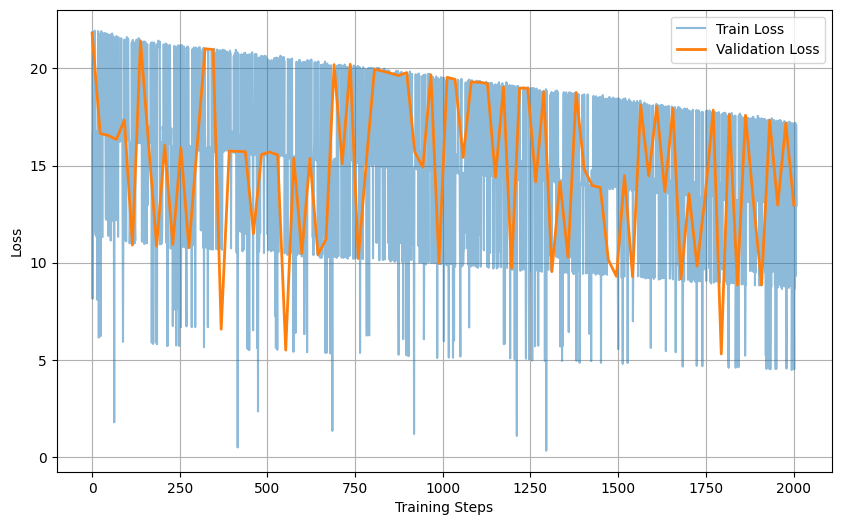

In [12]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss', alpha=0.5)
# Ensure validation points align with training points by using same length arrays
val_steps = range(0, len(train_losses), INTERLEAVE_EVERY)
val_losses_padded = val_losses + [val_losses[-1]] * (len(val_steps) - len(val_losses))
plt.plot(val_steps, val_losses_padded, label='Validation Loss', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Still trending downwards, only trained this for 20-30 minutes on my mac. 

Now we can try to see whether the SAE is picking up on something interesting.

In [14]:
subset = val_ds.shuffle(seed=42).select(range(100))
subset = [torch.tensor(x["chat_ids"])[None] for x in subset]

In [16]:
LAYER = N_LAYERS // 2  # maybe the middle is interesting

with torch.no_grad():
    activations = [model(x.to(DEVICE), output_hidden_states=True).hidden_states[LAYER].reshape(-1, HIDDEN_SIZE) for x in tqdm(subset)]

    activations = torch.cat(activations, dim=0)
    positions = torch.tensor([LAYER] * len(activations))
    
    indices, values = sae.encode(activations, positions)


In [17]:
values.min(), values.max(), values.mean(), values.std()

(tensor(13.4796, device='mps:0'),
 tensor(1119.9923, device='mps:0'),
 tensor(32.4044, device='mps:0'),
 tensor(48.9667, device='mps:0'))

In [18]:
counts = torch.bincount(indices.flatten(), minlength=HIDDEN_SIZE * 2)

sorted_indices = torch.sort(counts, descending=True).indices


In [21]:
def highlight_feature_activations(text, feature_idx, model, sae, tokenizer, device="mps"):
    RESET = "\033[0m"
    def get_color(value):
        normalized = max(0.0, min(1.0, math.log(value + 1e-5)))
        
        text_red = int(30 + 225 * normalized)  # increased range (30-255)
        
        bg_red = 255
        bg_green = bg_blue = int(255 - (80 * normalized))  # doubled the reduction (255-175)
        
        return f"\033[48;2;{bg_red};{bg_green};{bg_blue}m\033[38;2;{text_red};0;0m"
    
    # Tokenize and get model outputs
    tokens = tokenizer.encode(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(tokens, output_hidden_states=True)
        activations = outputs.hidden_states[LAYER]
        activations = activations.reshape(-1, model.config.hidden_size)
        positions = torch.tensor([LAYER] * len(activations))
        
        indices, values = sae.encode(activations, positions)
        
        # Create feature mask
        feature_mask = (indices == feature_idx).any(dim=1)
        feature_values = torch.zeros_like(feature_mask, dtype=torch.float)
        for i, (idx, val) in enumerate(zip(indices, values)):
            if feature_idx in idx:
                # Get top 5 values for this token
                top5_mask = torch.zeros_like(val, dtype=torch.bool)
                top5_indices = torch.topk(val, min(5, len(val))).indices
                top5_mask[top5_indices] = True
                
                # Check if our feature is in top 5
                if top5_mask[idx == feature_idx].any():
                    feature_values[i] = val[idx == feature_idx].max()
    
    # Decode tokens and apply colors
    tokens = tokens[0].cpu().numpy()
    decoded = []
    for i, token in enumerate(tokens):
        word = tokenizer.decode([token])
        if feature_values[i] > 0:  # Only highlight if it was in top 5
            color = get_color(feature_values[i].item())
            decoded.append(f"{color}{word}{RESET}")
        else:
            decoded.append(word)
    
    return "".join(decoded)

def highlight_feature(text, feature_idx, model, sae, tokenizer, device="mps"):
    example_text = tokenizer.decode(text[0], skip_special_tokens=True)
    colored_text = highlight_feature_activations(example_text, feature_idx, model, sae, tokenizer)
    print(colored_text)

Now we can at last highlight the features.

The most common activations appear to "overfire" in this small example we have done. 

In [22]:
highlight_feature(subset[1], sorted_indices[0], model, sae, tokenizer)

system
You are Qwen, a helpful coding assistant.
user
Create a Rust script snippet that Checks Low Oral health habits: Healthy Diet for Teeth for Analysis for Beginners. Use if/else or switch/case statements to conditionally perform different actions based on the Responsibility. Dry-run, then include comments that outline the control flow and how you handle different scenarios.
assistant
Here is a possible implementation of this functionality in Rust:
```rust 
fn check_low_oral_health(diet: &str) -> String {
    let mut result = "Good job! Your dietary choices seem to promote good oral health.".to_string();

    match diet {
        // Case 1: Unhealthy diet
        _ if diet == "junk food" || diet == "fast food" => {
            result = format!("{} However, eating too much junk food can lead to cavities and other dental problems.", result);
        }

        // Case 2: Healthy diet
        _ if diet == "vegetables" || diet == "fruits" => {
            result = format!("{} Keep up th

Some features I have naively labelled

In [26]:
highlight_feature(subset[-1], sorted_indices[9], model, sae, tokenizer)

system
You are Qwen, a helpful coding assistant.
user
Develop a C# program snippet to Display Low Finance: Investment Management for Analysis for Experts. Incorporate if/else or switch/case statements to handle various cases related to the Responsibility. Dry-run, ensure your control flow logic is clear and well-commented.
assistant
Here is some sample C# code which implements low finance investment management functionality as requested:

    ```csharp
    public class InvestmentManager
    {
        private double _initialInvestment;
        private int _yearsToGrowth;

        // Constructor
        public InvestmentManager(double initialInvestment, int yearsToGrowth)
        {
            this._initialInvestment = initialInvestment;
            this._yearsToGrowth = yearsToGrowth;
        }

        // Calculate interest earned based on time passed since initial deposit
        public double CalcInterestEarned()
        {
            return (_initialInvestment * (Math.Pow((1 + 0.05)

In [139]:
highlight_feature(subset[2], sorted_indices[89], model, sae, tokenizer)

system
You are Qwen, a helpful coding assistant.
user
Build a Go module snippet that Checks High Hygiene in shared spaces: Cleaning and Disinfecting Common Areas for Engineer for Experts. Incorporate if/else or switch/case statements to handle different cases based on the Privacy. Ensure your control flow is well-documented with comments explaining your approach.
assistant
Here's some sample Go code that implements high hygiene checks during cleaning and disinfection of common areas in a building:

    package main
    
    import (
        "fmt"
    )
    
    func CheckHygiene(privacy string) {
        // Determine appropriate action based on privacy level
        var action string
    
        switch privacy {
        case "public":
            fmt.Println("Disinfect all surfaces")
        case "private":
            fmt.Println("Wipe down surfaces with disinfectant wipes")
        default:
            fmt.Println("Invalid input")
        }
    }
    
    func Main() {
        Check

In [145]:
highlight_feature(subset[9], sorted_indices[9], model, sae, tokenizer)

system
You are Qwen, a helpful coding assistant.
user
Develop a Rust program snippet to Display Low Travel: Travel Itineraries for Decision Making for Beginners. Incorporate if/else or switch/case statements to handle various cases related to the Reliability. Dry-run, ensure your control flow logic is clear and well-commented.
assistant
Here's some sample Rust code that displays low travel: Travel itineraries for decision making for beginners based on reliability:
```rust 
fn main() {
    let mut user_input = String::new();

    println!("Enter destination:");
    std::io::stdin().read_line(&mut user_input)
        .expect("Failed to read input");
    
    match user_input.trim() {
        "London" => {
            println!("\nLowest fare from New York to London via Icelandair:\n$450 round trip including taxes")
        }
        "Paris" => {
            println!("\nCheapest flight from San Francisco to Paris:\n$782 one way on Air France")
        }
        _ => {
            println!(